<center>Thorsten Brückner<br>
<center>March 15, 2023<br><br><br>
<hr style="height:5px;border-width:0;color:orange;background-color:green">
<center><b><span style="font-size: 32px; color: green;"> User Segmentation</b></span></center>

<br><a id="0"></a>
<font color=green size=+3><b>1.1 Introduction</b></font><br>
<br>
EasyMoney is a financial services company that plans to enhance customer experience by providing personalized offerings based on their transaction and product interaction behavior. To achieve this goal, the company intends to segment its customers into meaningful groups based on their purchase history and overall spending patterns.<br>
<br>

Based on the previously conducted analysis, it has been determined that the provided sociodemographic data is not entirely reliable. Therefore, further investigation into this aspect will not be pursued, and the <font color=green><b>focus will be solely on commercial activity-related variables**</b></font> for segmentation purposes. This methodology considers key commercial variables, such as <b>recency, retention, frequency, and revenue</b>. Each variable will be clustered independently using k-means clustering to identify distinct customer groups based on their commercial acitivity for that respective variable.<br>
<br>
The resulting clusters will be combined to create an overall score for each customer, which will be used to segment customers into three meaningful groups: low-value, mid-value, and high-value customers. This will enable EasyMoney to tailor its products and services to the unique needs of each segment, thereby increasing customer satisfaction, retention, and profitability.<br>
<br>
In addition, historical data will be used to evaluate the effectiveness of these segments by predicting current revenue values based on the respective segments. This will help EasyMoney to optimize its marketing efforts and allocate resources more efficiently.
<br><br><br>

<font color=green><b>**</b></font> <font size=-1.5><i>It is important to acknowledge the limitations of the available data and exercise caution when drawing conclusions based solely on commercial activity-related variables. While these variables can offer valuable insights, they may not provide a complete understanding of the underlying factors that impact consumer behavior. In order to effectively segment the target audience and develop tailored strategies that cater to their unique needs and preferences, it is essential to carefully evaluate and analyze all available data sources and adopt a multidimensional approach that considers both commercial and non-commercial factors.</i></font><br>

<br><a id="0"></a>
<font color=green size=+3><b>1.2 Results Breakdown</b></font><br>
<br>
The segmentation process resulted in three clusters - <font color=green><b>Low-Value, Mid-Value, and High-Value.</b></font><br>
<font color=green><b>The High-Value segment</b></font> consists of loyal, high-spending customers<br>
<font color=green><b>The Mid-Value segment</b></font> has potential to become high-value customers but requires more attention in terms of retention and frequency of purchases. <br>
<font color=green><b>The Low-Value segment</b></font> comprises infrequent purchasers with lower spending patterns, requiring a strategy to increase their frequency of purchases to convert them into higher-value customers.<br>
<br>
After implementing the segmentation methodology a <b>successful</b> test was conducted. <br>
The test used historical data to predict customer behavior based on their respective segments. The results of the test showed a <font color=green><b>93% accuracy rate </b></font>in predicting customer behavior based on past patterns, which indicates that the segmentation process was effective in identifying meaningful customer groups based on their behavior.

This high accuracy rate suggests that EasyMoney can use the identified segments to tailor their products and services to the unique needs of each group. By doing so, they can increase customer satisfaction, retention, and profitability. The company can also allocate their resources more efficiently by optimizing their marketing efforts towards each segment, as the identified segments provide valuable insights into customer behavior.

Overall, the test results demonstrate that the segmentation methodology is a reliable approach for EasyMoney to identify meaningful customer groups and tailor their offerings accordingly.

<br><hr style="height:5px;border-width:0;color:orange;background-color:green">
<a id="0"></a>
<font color=green size=+3><b>2. Preparation</b></font><br>
<br>

<br><font color=green size=+2><b>2.1 - Module Imports & Configurations</b></font>

In [17]:
import numpy as np
import pandas as pd
from datetime import date

from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import cv, XGBClassifier

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

# Warnings 
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
# pandas formatting
pd.set_option("display.max_rows", 100)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("max_colwidth",200)
pd.set_option("display.colheader_justify", "center")

<br><font color=green size=+2><b>2.2 - Data Import</b></font>

In [3]:
df = pd.read_csv("../data/Bobs_df_delivery.csv")
df["pk_partition"] = pd.to_datetime(df["pk_partition"])
df["entry_date"] = pd.to_datetime(df["entry_date"])
df["pk_cid"] = df["pk_cid"].astype(int)

<br><font color=green size=+2><b>2.3 - Function Definitions</b></font><br>
Centralizing the necessary functions helps to maintain organization and clarity in the notebook.<br>
This allows easy calling as required without sacrificing the code's readability.

In [4]:
#############################################################
def cat_uni_values(data):

    """ Prints the unique values for each categorical column in the provided DataFrame. """

    cat = data.select_dtypes(include = ["object"])
    for columns in cat:
        categories = data[columns].unique()
        print("[{}] has {} unique values\n".format(columns, categories))


#############################################################
def numerical(data):

    """ Prints the number of numerical features in a provided DataFrame, and the number of unique values for each one. """
   
    num = data.select_dtypes(include=["int16", "int32", "int64", "float16", "float32", "float64"]).columns
    print("The dataframe contains [{}] numerical features out of [{}] features:".format(len(num),data.shape[1]))
    
    for columns in num:
        categories = len(data[columns].unique())
        print("Column [{}] has [{}] unique values".format(columns, categories))

        
#############################################################
def missing_values (data):
        
        """ Returns a DataFrame showing the number and percentage of missing values for each column in the provided DataFrame. """
        
        missing_number = data.isnull().sum().sort_values(ascending=False)
        missing_percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)*100
        missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=["Missing_Number", "Percentage %"])
        return missing_values


#############################################################
def print_formatted_word(word):

    """ my 5 minutes of extreme sillyness """

    total_length = len("####################  SCORES & EVALUATIONS  #############################")
    word_length = len(word)
    num_of_hashes_before = len("####################  ")
    num_of_hashes_after = total_length - (num_of_hashes_before + word_length)
    print("#" * num_of_hashes_before + " " + word + " " + "#" * num_of_hashes_after)


##############################################################
def order_cluster(cluster_field_name, target_field_name, df, ascending):

    """
    Orders a DataFrame based on the mean of a target column for each value of a cluster column.

    Args:
        cluster_field_name (str): The name of the column containing the cluster values.
        target_field_name (str): The name of the column containing the target values to use for ordering.
        df (pandas.DataFrame): The DataFrame to be ordered.
        ascending (bool): Whether to sort the DataFrame in ascending order (True) or descending order (False).

    Returns:
        pandas.DataFrame: The ordered DataFrame with a new cluster column.
    """

    new_cluster_field_name = "new_" + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by = target_field_name,ascending = ascending).reset_index(drop=True)
    df_new["index"] = df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, "index"]], on = cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns = {"index": cluster_field_name})

    return df_final


##############################################################
def CLUSTER_maker(data, clusters, feature):

    """
    Uses K-means clustering to create a new column with cluster labels based on the values of a given feature.

    Args:
        data (pandas.DataFrame): The DataFrame containing the feature values to cluster.
        clusters (int): The number of clusters to create.
        feature (str): The name of the column containing the feature values to cluster.

    Returns:
        pandas.DataFrame: A DataFrame containing a new column with cluster labels based on the feature values.
    """

    data_ = data.copy(deep = True)
    kmeans = KMeans(n_clusters = clusters)
    kmeans.fit(data_[[feature]])
    data_[feature + "Cluster"] = kmeans.predict(data_[[feature]])

    return data_[[feature + "Cluster"]]


##############################################################
def product_summarizer(data):

    """
    Creates new columns in a DataFrame that summarize total values for different product categories.

    Args:
        data (pandas.DataFrame): The DataFrame to summarize.

    Returns:
        pandas.DataFrame: A copy of the input DataFrame with additional columns that summarize total values for different product categories.
    """
        
    data_ = data.copy(deep = True)
    Total_accounts = ["payroll", "payroll_account", "emc_account", "em_acount"]
    Total_loans = ["loans", "mortgage", "credit_card", "debit_card"]
    Total_funds = ["short_term_deposit", "funds", "securities", "long_term_deposit", "pension_plan"]

    data_["Total_funds"] = data_[Total_funds].sum(axis = 1)
    data_["Total_loans"] = data_[Total_loans].sum(axis = 1)
    data_["Total_accounts"] = data_[Total_accounts].sum(axis = 1)

    return data_


##############################################################
def RECENCY_maker(data, plot_1 = True, plot_2 = True):

    """
    Returns a dataframe with Recency and RecencyCluster columns for each customer.

    Args:
    data (pd.DataFrame): The input dataframe containing customer transaction data with pk_cid and pk_partition columns.
    plot_1 (bool): A boolean value indicating whether to plot the histogram of Recency or not. Default is True.
    plot_2 (bool): A boolean value indicating whether to plot the elbow plot of k-means clustering or not. Default is True.

    Returns:
    pd.DataFrame: A dataframe with Recency and RecencyCluster columns for each customer.
    """

    df_sorted = data.sort_values(["pk_cid", "pk_partition"])
    max_partition = df_sorted.groupby("pk_cid")["pk_partition"].max().reset_index()
    last_change = df_sorted.loc[df_sorted["Total_products"].diff() != 0].groupby("pk_cid")["pk_partition"].max().reset_index()
    last_change = pd.merge(max_partition, last_change, on = "pk_cid", how = "left")
    last_change["pk_partition"] = last_change["pk_partition_y"].fillna(last_change["pk_partition_x"])
    last_change.drop(["pk_partition_x", "pk_partition_y"], axis = 1, inplace = True)
    last_change.columns = ["CustomerID", "Last_Purchase"]

    df_date = data[["pk_cid","pk_partition"]]
    df_date.columns = ["CustomerID", "pk_partition"]

    last_change = pd.merge(last_change, df_date, on = "CustomerID", how = "left")
    last_change["Recency"] = (last_change["pk_partition"].max()- last_change["Last_Purchase"]).dt.days
    last_change.set_index("CustomerID", inplace = True)
    last_change.sort_values(by = "Recency", ascending = False, inplace = True)
    last_change.drop(["Last_Purchase", "pk_partition"], axis = 1, inplace = True)
    
    recency_df = pd.DataFrame(last_change.groupby("CustomerID")["Recency"].max()).reset_index()
    
    if plot_1:
        plt.hist(last_change["Recency"], bins = 10)

    if plot_2:
        SSE = {}
        for k in range(1, 10):
            kmeans = KMeans(n_clusters = k, max_iter = 1000).fit(recency_df)
            SSE[k] = kmeans.inertia_ 
        plt.figure()
        plt.plot(list(SSE.keys()), list(SSE.values()))
        plt.xlabel("Number of cluster")
        plt.show()
    
    recency_df.sort_values(by = "Recency", ascending = True, inplace = True)
    recency_cluster_series = CLUSTER_maker(recency_df, 3, "Recency")
    
    recency_df = pd.concat([recency_df, recency_cluster_series], axis = 1)
    recency_df = order_cluster("RecencyCluster", "Recency", recency_df, False)
    display(recency_df.groupby("RecencyCluster")["Recency"].describe())
    recency_df.set_index("CustomerID", inplace = True)

    return recency_df


##############################################################
def RETENTION_values(data, plot_1 = True):

    """
    Returns a DataFrame with retention values and their respective clusters for each customer.
    
    Args:
        data (DataFrame): The input DataFrame containing customer data.
        plot_1 (bool, optional): Whether to plot a histogram of the retention values. Defaults to True.
    
    Returns:
        DataFrame: A DataFrame with retention values and their respective clusters for each customer.
    """

    data_ = data.copy(deep = True)
    df_retention = data_.groupby("pk_cid").pk_partition.count().reset_index()
    df_retention.columns = ["CustomerID","Retention"]

    if plot_1:
        plt.hist(df_retention.query("Retention < 1000")["Retention"], bins = 10)

    df_retention.sort_values(by = "Retention", ascending = True, inplace = True)
    retention_cluster_series = CLUSTER_maker(df_retention, 4, "Retention")

    df_retention = pd.concat([df_retention, retention_cluster_series], axis = 1)
    df_retention = order_cluster("RetentionCluster", "Retention", df_retention, True)
    display(df_retention.groupby("RetentionCluster")["Retention"].describe())
    df_retention.set_index("CustomerID", inplace = True)

    return df_retention


##############################################################
def FREQUENCY_values(data, plot = True):

    """
    Calculates the frequency of customer transactions using the provided data.

    Args:
        data (pandas.DataFrame): The input data containing customer transaction information.
        plot (bool, optional): A flag indicating whether to display a histogram of frequency. Default is True.

    Returns:
        pandas.DataFrame: A dataframe with CustomerID and Frequency columns, as well as cluster information.
    """
        

    data_ = data.copy(deep = True)
    PRODUCT_SUM = product_summarizer(data_)

    PRODUCT_SUM = PRODUCT_SUM[["pk_cid", "pk_partition", "entry_date", "Total_funds", "Total_loans", "Total_accounts"]]
    PRODUCT_SUM = PRODUCT_SUM.groupby("pk_cid").sum()
    store_ID = PRODUCT_SUM.groupby("pk_cid").sum().reset_index()
    
    frequency = PRODUCT_SUM.diff().fillna(0)
    frequency["Frequency"] = frequency.sum(axis = 1)
    
    frequency_df = pd.DataFrame(frequency["Frequency"])
    frequency_df.columns = ["Frequency"]
    if plot:
        freq = frequency["Frequency"][np.isfinite(frequency["Frequency"])]
        plt.hist(freq, bins=10)
        plt.show()

    frequency_df.reset_index(inplace = True)
    frequency_df.rename(columns = {"pk_cid": "CustomerID"}, inplace = True)
    frequency_df.sort_values(by = "Frequency", ascending = True, inplace = True)
    frequency_cluster_series = CLUSTER_maker(frequency_df, 4, "Frequency")

    frequency_df = pd.concat([frequency_df, frequency_cluster_series], axis = 1)
    frequency_df = order_cluster("FrequencyCluster", "Frequency", frequency_df, True)
    display(frequency_df.groupby("FrequencyCluster")["Frequency"].describe())
    frequency_df.set_index("CustomerID", inplace = True)

    return frequency_df


##############################################################
def REVENUE_values(data, plot = True):

    """
    Calculates the revenue generated by each customer and assigns them to a cluster based on their revenue. 

    Parameters:
    data (pd.DataFrame): Input data.
    plot (bool): Whether to plot a histogram of the frequency distribution of the revenue.

    Returns:
    pd.DataFrame: A dataframe with the customer IDs as the index and the revenue and revenue cluster as columns.
    """

    data_ = data.copy(deep = True)
    PRODUCT_SUM = product_summarizer(data_)
    PRODUCT_SUM["Revenue"] = (PRODUCT_SUM["Total_funds"] * 60 + 
                                PRODUCT_SUM["Total_loans"] * 40 + 
                                PRODUCT_SUM["Total_accounts"] * 10)
    REVENUE_SUM = PRODUCT_SUM.groupby("pk_cid")["Revenue"].sum().reset_index()

    REVENUE_SUM.sort_values(by = "Revenue", ascending = True, inplace = True)
    REVENUE_cluster_series = CLUSTER_maker(REVENUE_SUM, 4, "Revenue")

    REVENUE_SUM = pd.concat([REVENUE_SUM, REVENUE_cluster_series], axis = 1)
    REVENUE_SUM = order_cluster("RevenueCluster", "Revenue", REVENUE_SUM, True)
    display(REVENUE_SUM.groupby("RevenueCluster")["Revenue"].describe())
    REVENUE_SUM.rename(columns = {"pk_cid": "CustomerID"}, inplace = True)
    REVENUE_SUM.set_index("CustomerID", inplace = True)

    return REVENUE_SUM



##############################################################
def OVERALL_score_maker(RECENCY, RETENTION, FREQUENCY, REVENUE):
    
    """
    Combines the Recency, Retention, Frequency, and Revenue scores for each customer into a single Overall Score.
    
    Parameters:
        - RECENCY: A pandas DataFrame containing Recency scores for each customer
        - RETENTION: A pandas DataFrame containing Retention scores for each customer
        - FREQUENCY: A pandas DataFrame containing Frequency scores for each customer
        - REVENUE: A pandas DataFrame containing Revenue scores for each customer
        
    Returns:
        - SCORE_DF: A pandas DataFrame containing the Overall Score, as well as the individual Recency, Retention, Frequency, and Revenue scores for each customer.
    """
    
    SCORE_DF = pd.concat([RECENCY, RETENTION, FREQUENCY, REVENUE], axis = 1)
    SCORE_DF["OverallScore"] = (SCORE_DF["RecencyCluster"] + 
                                SCORE_DF["FrequencyCluster"] + 
                                SCORE_DF["RevenueCluster"] + 
                                SCORE_DF["RetentionCluster"])
    display(SCORE_DF.groupby("OverallScore")[["Recency", "Retention", "Frequency", "Revenue"]].mean())
    return SCORE_DF

<br><font color=green size=+2><b>2.3 - Global Variables</b></font>

In [5]:
products = ["short_term_deposit", "loans", "mortgage","funds", "securities", 
            "long_term_deposit", "credit_card", "debit_card","payroll", 
            "pension_plan", "payroll_account", "emc_account", "em_acount"]

<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">
<font color=green size=+3><b>3. Segmentation / Cluster Definition</b></font><br>
<br>

<br><font color=green size=+2><b>3.0 - RRFM METHODOLOGY</b></font><br>
Recency, Retention, Frequency & Monetary Value

RFM is a widely used method in customer segmentation and customer relationship management. It stands for <b>Recency, Frequency, and Monetary Value</b>, which are used to analyze and categorize customers based on their transactional behavior. In this scenario, a fourth dimension, <b>Retention</b>, has been introduced due to the subscription-based model. Retention measures the number of months a user has an active subscription. Thus, the method used in this scenario is called <font color=green><b>RRFM</b></font>.<br>
<br><br>
<u>Metrics breakdown:</u><br>
<br>

<font color=green><b>Recency</b></font>: How recently has the customer engaged in commercial activity**? This metric measures the time elapsed since the customer's last commercial transaction.<br>
<br>
<font color=green><b>Retention</b></font>: How many months, within the specified recording period, did the customer engage in commercial activity**? This metric measures the total sum of months during which the customer had any type of commercial transaction.<br>
<br>
<font color=green><b>Frequency</b></font>: How frequently does the customer engage in commercial activity**? This metric measures the total number of commercial transactions made by the customer within a specified time period.<br>
<br>
<font color=green><b>Monetary Value</b></font>: How much money has the customer spent on commercial activity**? This metric measures the total amount of money spent by the customer on any type of commercial transaction within a specified time period.<br>
<br>
Analyzing Recency, Retention, Frequency & Monetary Value can enable businesses to segment customers based on their transactional behavior, thus allowing for targeted marketing and communication strategies tailored to each group's specific needs and preferences. <br>For instance, customers who made recent, high-value purchases may receive offers for related products or services, while those who haven't purchased in a long time may receive incentives to return and make a purchase. The <font color=green><b>RRFM method</b></font> is a valuable tool for businesses seeking to enhance customer engagement, retention, and revenue.<br><br>
<br>
<font color=green><b>**</b></font> <font size=-1.5><i>For the purpose of this scenario, commercial activity is defined as any instance of a customer engaging in a revenue-generating transaction, such as making a single product purchase, utilizing a product in a way that generates income for the company, or having an active subscription to a product.</i></font><br><br><br>

<br><font color=green size=+2.5><b>3.1 - Recency Calculation</b></font><br>
Time elapsed since the customer's last commercial transaction.<br>
<br><br>
The recency metric was calculated by first sorting the dataset by customer ID and transaction date.<br>
Next, the last date where the total number of products purchased by a customer was not equal to the previous value was identified. This date was then used to calculate the recency metric, which measures the number of days between the observation point (the maximum transaction date in the dataset) and the last purchase date for each customer. Finally the clusters are arranged in order, with the higher cluster number indicating a lower recency number.<br>
<br>
The attached histogram visualizes the distribution of recency across customers, the table describes the 3 created clusters numerically.<br>
The calculated recency and the respective clusters are stored in the <font color=green><b>RECENCY_ALL</b></font> dataframe, indexed by the unique customer IDs.<br><br>

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,65099.000,471.934,31.860,365.000,485.000,485.000,485.000,485.000
1,116520.000,252.926,55.264,151.000,212.000,273.000,304.000,334.000
2,271919.000,12.724,30.440,0.000,0.000,0.000,0.000,120.000


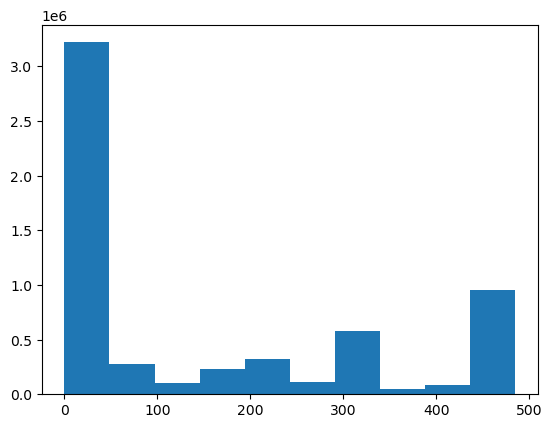

In [6]:
RECENCY_ALL= RECENCY_maker(df, True, False)

<br><font color=green size=+2.5><b>3.2 - Retention Calculation</b></font><br>
Total sum of months during which the customer had any type of commercial transaction.<br>
<br><br>
The retention metric is calculated by summing the total number of months in which a user showed either activity with a product or had an active subscription for respective products. The cluster order is defined with the higher cluster number indicating a higher retention number.<br>
<br>
The histogram attached illustrates the distribution of retention rates across customers, while the accompanying table presents a numerical description of the four clusters created. <br>
The calculated retention value and its respective clusters are stored in the <font color=green><b>RETENTION_ALL</b></font> dataframe, indexed by the unique customer IDs.<br><br>

,count,mean,std,min,25%,50%,75%,max
RetentionCluster,,,,,,,,
0,33455.000,2.893,1.487,1.000,1.000,3.000,4.000,5.000
1,72984.000,7.891,0.965,6.000,7.000,8.000,9.000,9.000
2,103458.000,10.974,0.567,10.000,11.000,11.000,11.000,13.000
3,243641.000,16.902,0.464,14.000,17.000,17.000,17.000,17.000


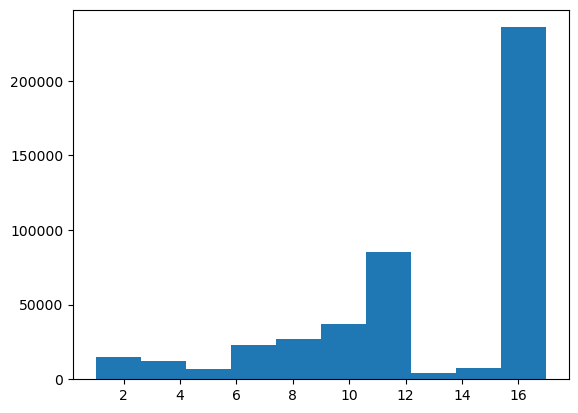

In [7]:
RETENTION_ALL = RETENTION_values(df, plot_1 = True)

<br><font color=green size=+2.5><b>3.3 - Frequency Calculation</b></font><br>
Total number of commercial transactions made by the customer within a specified time period.<br>
<br><br>
The calculation process involves determining the activation count for each product type (funds, loans, and accounts) for each customer and adding them up to obtain the total frequency of activations. A negative activation count signifies that the corresponding product was deactivated or cancelled by the customer, while a zero activation count indicates that the customer did not activate or deactivate the product during the given time period. A positive activation count means that the customer activated a new product during the given time period.<br>
<br>
The attached histogram displays the distribution of frequency rates among customers, while the accompanying table provides a numerical description of the 4 clusters that were created. <br>
The calculated frequency value and the respective clusters are stored in the <font color=green><b>FREQUENCY_ALL</b></font> dataframe, indexed by the unique customer IDs.<br><br>

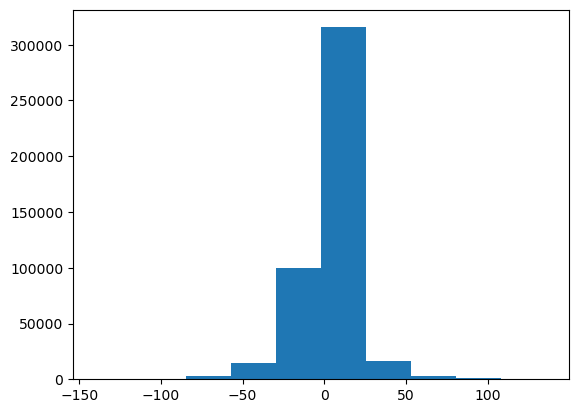

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,68296.000,-25.154,14.889,-140.000,-30.000,-17.000,-17.000,-13.000
1,293229.000,-0.758,3.421,-12.000,0.000,0.000,0.000,7.000
2,76235.000,15.628,5.376,8.000,11.000,17.000,17.000,31.000
3,15778.000,47.457,15.964,32.000,34.000,43.000,55.000,136.000


In [8]:
FREQUENCY_ALL = FREQUENCY_values(df)

<br><font color=green size=+2.5><b>3.4 - Revenue Calculation</b></font><br>
Total amount of money spent by the customer on any type of commercial transaction within a specified time period<br>
<br><br>
The products are categorized into funds, loans, and accounts, each with an associated revenue amount assumed to be 60€ for loans, 40€ for funds, and 10€ per account. The calculation of revenue involves summing the amount of sales, which is equivalent to each month of active subscription or product activity, and multiplying them with the corresponding revenue values. It is important to note that the revenue values are based on estimations and may not accurately reflect the actual revenue generated. However, the validity of the calculation is based on the assumption that the proportions are correct.<br>
<br>
The attached table displays a numerical description of the 4 created clusters. <br>
The calculated revenue and the respective clusters are stored in the <font color=green><b>REVENUE_ALL</b></font> dataframe, indexed by the unique customer IDs.<br><br>

In [9]:
REVENUE_ALL = REVENUE_values(df, plot = True)

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,191594.000,34.055,41.775,0.000,0.000,0.000,80.000,110.000
1,217268.000,196.810,75.056,120.000,170.000,170.000,170.000,540.000
2,34848.000,889.789,229.156,550.000,720.000,850.000,1020.000,1460.000
3,9828.000,2035.444,477.398,1470.000,1690.000,1940.000,2220.000,5770.000


<br><font color=green size=+2.5><b>3.5 - Overall Score</b></font><br>
Total score.<br>
<br><br>
The points of separation were determined through a manual process, with the attached table providing assistance. An overall score below 5 indicates high recency, low retention, negative frequency, and low or no revenue. Scores between 5 and 8 demonstrate relatively recent activity, higher retention, no negative frequency, and rising revenue. Above an overall score of 8, all metrics show respective top values. Based on these observations, three segments were created: <font color=green><b>Low_Value, Mid_Value, and High_Value</b></font>.<br>
<br>
<font color=orange><b>The High Value Segment</b></font> represents customers with a high overall score, indicating that they are loyal, high-spending customers. In contrast, <font color=blue><b>the Mid Value Segment</b></font> consists of customers with a moderate overall score and the potential to become high-value customers with more attention. The strategy for this segment should be to <font color=blue>improve retention while increasing the frequency</font> of their purchases. Lastly, <font color=green><b>the Low Value Segment</b></font> comprises customers with a low overall score, indicating that they are infrequent purchasers and spend less than the other segments. The strategy for this segment should be to <font color=green>increase the frequency</font> of their purchases, converting them into higher-value customers over time.<br><br>

In [10]:
SCORE_ALL = OVERALL_score_maker(RECENCY_ALL, RETENTION_ALL, FREQUENCY_ALL, REVENUE_ALL)

SCORE_ALL.loc[SCORE_ALL["OverallScore"] <= 5, "Segment"] = "Low_Value" 
SCORE_ALL.loc[SCORE_ALL["OverallScore"] > 5, "Segment"] = "Mid_Value" 
SCORE_ALL.loc[SCORE_ALL["OverallScore"] > 7, "Segment"] = "High_Value"

,Recency,Retention,Frequency,Revenue
OverallScore,,,,
0,435.459,4.054,-23.459,15.676
1,277.496,2.882,-22.387,7.990
2,227.116,4.610,-13.689,11.917
3,205.305,8.024,-12.557,16.308
4,160.359,10.031,-5.498,92.164
5,113.828,11.751,-1.063,109.651
6,364.233,15.851,9.869,239.312
7,28.299,16.818,0.991,224.297
8,156.991,16.475,16.678,728.720


<br><font color=green size=+2.5><b>3.6 - Segmentation Visualization</b></font><br>
<br>
The below attached plots demonstrate that the clustering method has effectively separated the three segments. Each segment is clearly visible and distinguished by its respective color in both the 2-dimensional and 3-dimensional plots. This is an encouraging indication that our segmentation strategy is producing meaningful results.

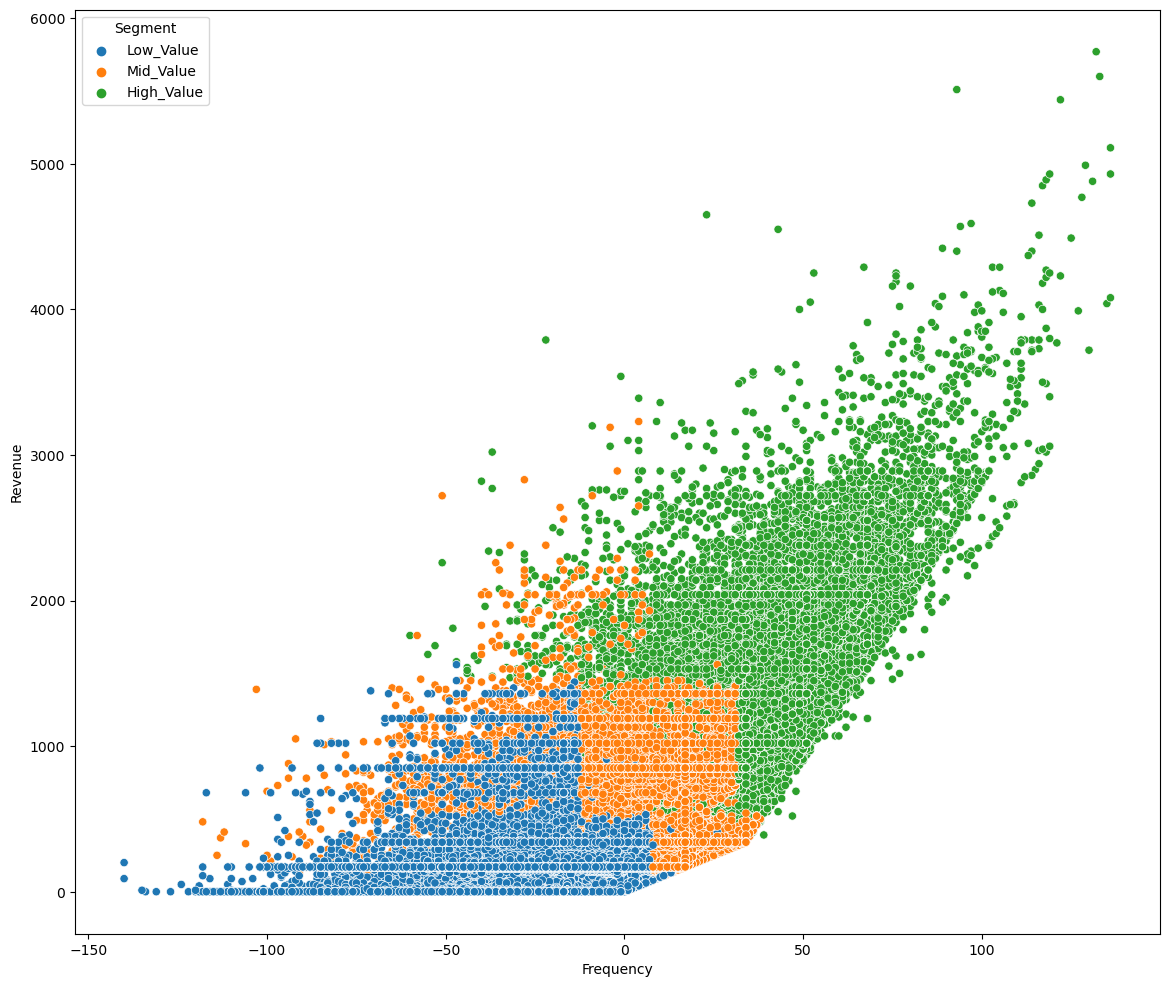

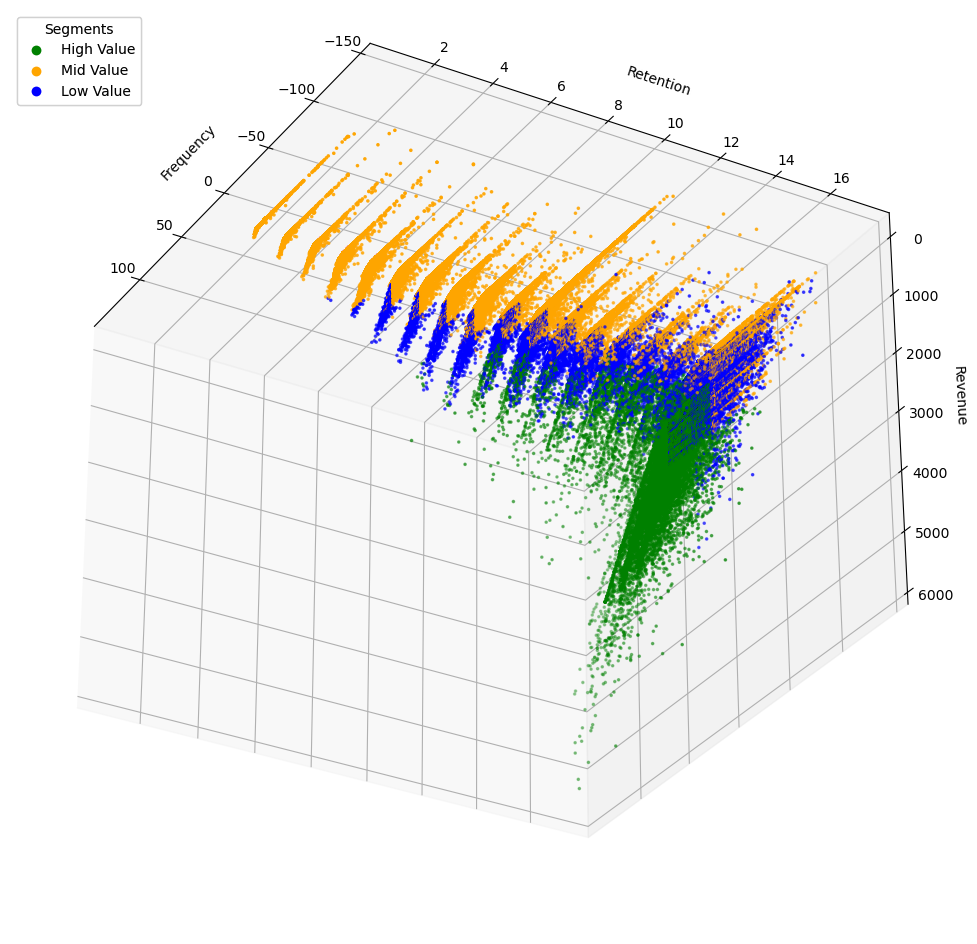

In [16]:
plt.figure(figsize = (14, 12))
sns.scatterplot(data = SCORE_ALL, x = "Frequency", y = "Revenue", hue = "Segment")
plt.xlabel("Frequency")
plt.ylabel("Revenue")
plt.show()

fig = plt.figure(figsize = (14 ,12))
ax = fig.add_subplot(111, projection = "3d")
scatter = ax.scatter(
    xs = SCORE_ALL["Frequency"], ys = SCORE_ALL["Retention"], zs = SCORE_ALL["Revenue"],
    c = SCORE_ALL["Segment"].astype("category").cat.codes,
    cmap = colors.ListedColormap(['green', 'orange', 'blue']), vmin = 0, vmax = 2, marker = ".", s = 10)

ax.set_xlabel("Frequency")
ax.set_ylabel("Retention")
ax.set_zlabel("Revenue")
legend = ax.legend(*scatter.legend_elements(), loc = "upper left", title = "Segments")
ax.add_artist(legend)
ax.view_init(elev = 150, azim = 30)
legend.get_texts()[0].set_text("High Value")
legend.get_texts()[1].set_text("Mid Value")
legend.get_texts()[2].set_text("Low Value")
plt.show()

<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">
<font color=green size=+3><b>4. Customer Life Time Value</b></font><br>

The following section will provide a description of the proposed correctness test, which aims to challenge the segmentation model in the context of the general theory of Lifetime Value (LTV). LTV is a commonly used term in business and marketing, referring to the total amount of money that a customer is expected to spend on a company's products or services throughout their relationship with the company.<br>
<br>
The assumption that we will be testing is that customers identified as having a high LTV early on will remain high LTV customers over time, assuming no company-wide strategy changes. To test this assumption, we will apply our segmentation model to the oldest historical data available, segmenting customers accordingly, and then compare their revenue behavior with more recent data.<br>
<br>
This test aims to verify the accuracy of our segmentation model and confirm whether the identified segments make sense, given that no changes have been made to the company's overall strategy.<br>

<br><font color=green size=+2.5><b>4.0 - Methodology</b></font><br>
<br>
In order to predict the Life Time Value (LTV) of our customers, a specific process will be followed. Firstly, a reference period of six months of the oldest historical data will be defined for training the machine learning model. Following this, the most recent 11 months will be used to test the model and evaluate its accuracy.<br>
<br>
The LTV will be predicted using the Revenue feature from the dataset. Our objective will be to predict the revenue of users based on the data from the oldest six months. Since no cost is specified in the dataset, we will use revenue as a proxy for LTV.<br>
<br>
The machine learning model will be built and run using XGBoost classification, which is suitable for classification tasks and will allow us to predict whether a customer will have high or low LTV. By training the model on the oldest data, we can obtain a more accurate understanding of the relationship between the features and LTV. Once the model has been trained, we will test it against the most recent 11 months of data to evaluate its accuracy.<br>
<br>

<br><font color=green size=+2.5><b>4.1 - Segmentation of historical data</b></font><br>
<br>

This section will apply the same steps & functions to create our overall segmentation on the historical data.
For reference the tables display the summary statistics for each metric again, as previously for the overall segmentation.

In [18]:
start_6m = pd.to_datetime(date(2018,1,28))
end_6m = pd.to_datetime(date(2018,6,28))
start_11m = pd.to_datetime(date(2018,6,28))
end_11m = pd.to_datetime(date(2019,5,28))

TEST_6M = df[(df.pk_partition < end_6m) & (df.pk_partition >= start_6m)].reset_index(drop=True)
TEST_11M = df[(df.pk_partition >= start_11m) & (df.pk_partition < end_11m)].reset_index(drop=True)

In [19]:
RECENCY_6M = RECENCY_maker(TEST_6M, False, False)
RETENTION_6M = RETENTION_values(TEST_6M, plot_1 = False)
FREQUENCY_6M = FREQUENCY_values(TEST_6M, plot = False)
REVENUE_6M = REVENUE_values(TEST_6M, plot = False)
SCORE_6M = OVERALL_score_maker(RECENCY_6M, RETENTION_6M, FREQUENCY_6M, REVENUE_6M)

SCORE_6M.loc[SCORE_6M["OverallScore"] <= 5, "Segment"] = "Low_Value" 
SCORE_6M.loc[SCORE_6M["OverallScore"] > 5, "Segment"] = "Mid_Value" 
SCORE_6M.loc[SCORE_6M["OverallScore"] > 7, "Segment"] = "High_Value"

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,42712.000,120.000,0.000,120.000,120.000,120.000,120.000,120.000
1,13766.000,72.919,13.845,61.000,61.000,61.000,89.000,89.000
2,194397.000,1.349,6.217,0.000,0.000,0.000,0.000,30.000


,count,mean,std,min,25%,50%,75%,max
RetentionCluster,,,,,,,,
0,7294.000,1.500,0.500,1.000,1.000,1.000,2.000,2.000
1,4061.000,3.000,0.000,3.000,3.000,3.000,3.000,3.000
2,4368.000,4.000,0.000,4.000,4.000,4.000,4.000,4.000
3,235152.000,5.000,0.000,5.000,5.000,5.000,5.000,5.000


,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,12449.000,-12.344,4.702,-39.000,-15.000,-11.000,-9.000,-7.000
1,205359.000,-0.442,1.451,-6.000,0.000,0.000,0.000,2.000
2,26753.000,5.413,2.049,3.000,4.000,5.000,6.000,10.000
3,6314.000,15.777,4.190,11.000,13.000,15.000,18.000,38.000


,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,211610.000,51.631,16.609,0.000,50.000,50.000,50.000,140.000
1,23386.000,232.973,39.623,150.000,210.000,250.000,250.000,310.000
2,10078.000,403.956,62.878,320.000,350.000,400.000,450.000,540.000
3,5801.000,684.787,134.185,550.000,600.000,640.000,750.000,1700.000


,Recency,Retention,Frequency,Revenue
OverallScore,,,,
0,120.000,1.163,-12.477,4.884
1,110.056,1.335,-6.869,8.155
2,59.501,2.045,-7.605,23.893
3,70.636,3.489,-7.349,40.618
4,105.303,4.743,-4.074,60.674
5,77.183,4.716,-0.181,106.609
6,6.087,4.993,0.136,62.784
7,47.867,4.973,2.707,257.281
8,34.751,4.992,4.731,327.687


The revenue has been defined as the LTV indicator and will be used as the reference target for the predictions. No further modification on recent data is required.

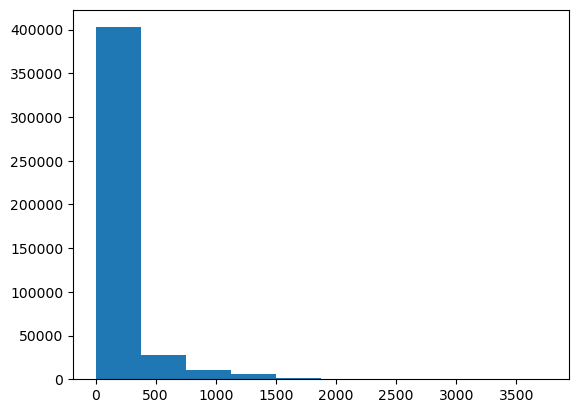

In [24]:
SCORE_11M = product_summarizer(TEST_11M)
SCORE_11M["Revenue"] = (SCORE_11M["Total_funds"] * 60 + 
                            SCORE_11M["Total_loans"] * 40 + 
                            SCORE_11M["Total_accounts"] * 10)

SCORE_11M = SCORE_11M.groupby("pk_cid")["Revenue"].sum().reset_index()
SCORE_11M.columns = ["CustomerID", "Revenue_11M"]

plt.hist(SCORE_11M["Revenue_11M"], bins = 10)
plt.show()

The historical data and recent data are merged after calculating the relevant score. This is done in order to prepare the final dataframe, DF_18, for modeling purposes.

In [25]:
DF_18 = pd.merge(SCORE_6M, SCORE_11M, on = "CustomerID", how = "left")
DF_18 = DF_18.fillna(0)

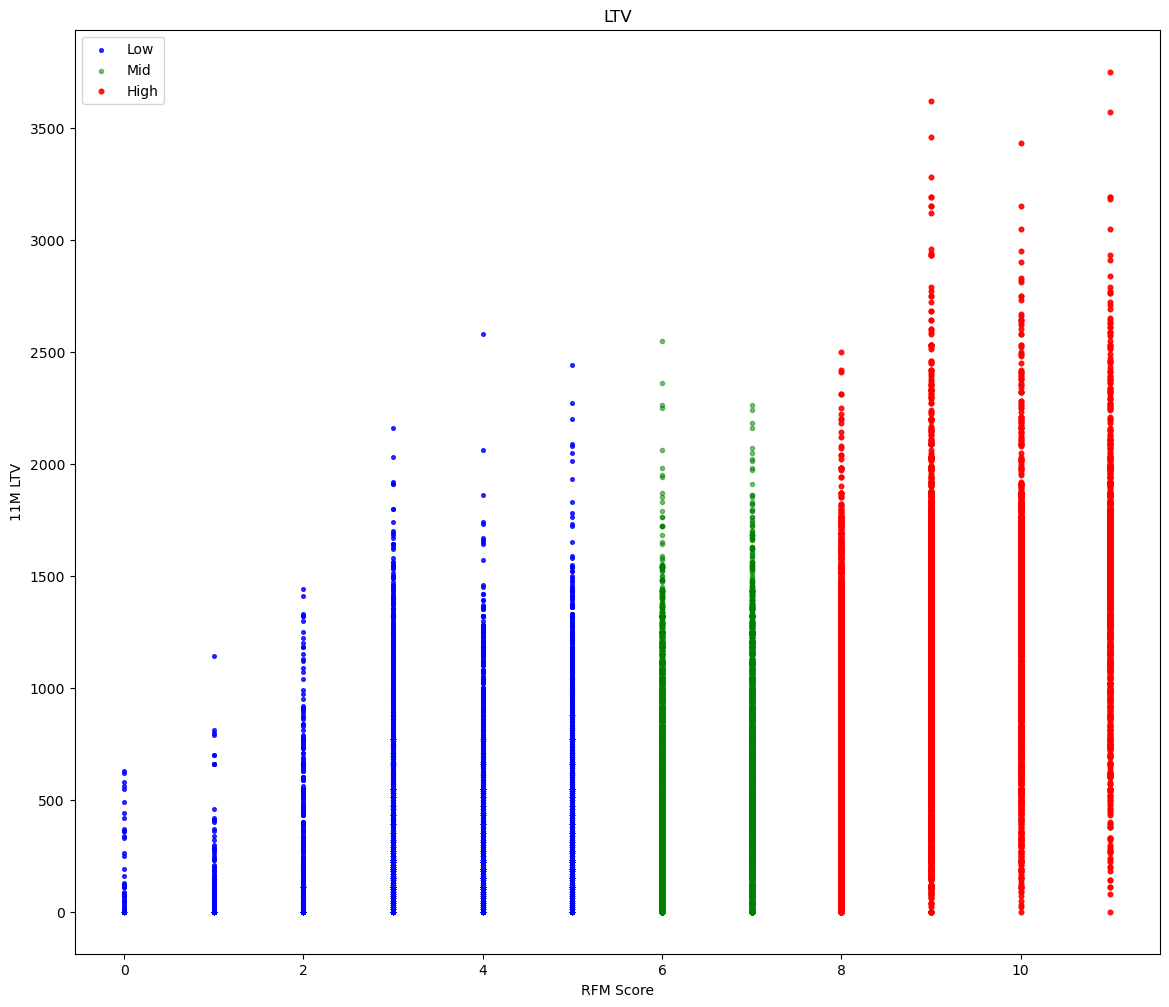

In [26]:
low_value = DF_18.query("Segment == 'Low_Value'")
mid_value = DF_18.query("Segment == 'Mid_Value'")
high_value = DF_18.query("Segment == 'High_Value'")
fig, ax = plt.subplots(figsize = (14, 12))
ax.scatter(
    low_value["OverallScore"], low_value["Revenue_11M"], s = 7, color = "blue", alpha = 0.8, label = "Low")
ax.scatter(
    mid_value["OverallScore"], mid_value["Revenue_11M"], s = 9, color = "green", alpha = 0.5, label = "Mid")
ax.scatter(
    high_value["OverallScore"], high_value["Revenue_11M"], s = 11, color = "red", alpha = 0.9, label = "High")
ax.set_xlabel("RFM Score")
ax.set_ylabel("11M LTV")
ax.set_title("LTV")
ax.legend()
plt.show()

<font color=green><b>Guidance reading the plot:</b></font><br>
<br>
The LTV vs RRFM plot can provide insights into the relationship between customer value and RFM scores, which are a measure of customer engagement and behavior. Here are a few things one might be able to learn from the plot:<br>
<br>
High-value customers tend to have higher RRFM scores than low-value customers. This is because high-value customers are typically more engaged and loyal, which is reflected in their RRFM scores. You can see this trend in the plot by noting that the red points (representing high-value customers) tend to be clustered in the upper-right corner of the plot, where both RFM scores and LTV are high.<br>
<br>
There may be a correlation between RFM scores and LTV. This is because RRFM scores are based on customer behavior, and behavior can be a good indicator of future spending. You can look for evidence of this correlation in the plot by observing whether the scatter points are clustered along a diagonal line. If there is a strong positive correlation between RRFM scores and LTV, you might expect to see a diagonal trend where the red points (representing high-value customers) are clustered in the upper-right corner of the plot, the green points (representing mid-value customers) are clustered in the middle, and the blue points (representing low-value customers) are clustered in the lower-left corner.<br>
<br>
There may be outliers or anomalies in the data that warrant further investigation. For example, you might notice a low-value customer with a high LTV, or a high-value customer with a low LTV. These anomalies might be explained by factors such as seasonality, marketing campaigns, or changes in customer behavior over time. By identifying these anomalies, you can gain insights into how to optimize your marketing and customer retention strategies.<br>
<br>
<font color=green><b>Overall (pre)conclusion:</b></font><br>
The trend that can be observed in which higher RRFM scores are associated with higher revenue indicates that the LTV theorem is correct and applicable for EasyMoney's customer segmentation.<br>
<br><br>

<br><font color=green size=+2.5><b>4.3 - LTV Clusters</b></font><br>
<br>

In [29]:
DF_CLUSTER = CLUSTER_maker(DF_18, 3, "Revenue_11M")
DF_CLUSTER = pd.concat([DF_CLUSTER, DF_18], axis = 1)
DF_CLUSTER.rename(columns = {"Revenue_11MCluster": "LTVCluster"}, inplace = True)
DF_CLUSTER = order_cluster("LTVCluster", "Revenue_11M", DF_CLUSTER, True)

DF_CLUSTER = DF_CLUSTER.copy()
DF_CLUSTER["CustomerID"] = DF_CLUSTER["CustomerID"].astype(int)

best_cust_list = DF_CLUSTER.query("LTVCluster==2")["CustomerID"].unique().tolist()
display(DF_CLUSTER.groupby("LTVCluster")["Revenue_11M"].describe())

df_class = pd.get_dummies(DF_CLUSTER)
corr_matrix = df_class.corr()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,209199.000,117.921,46.879,0.000,110.000,110.000,110.000,360.000
1,31449.000,607.875,152.796,370.000,510.000,550.000,720.000,980.000
2,10227.000,1357.557,305.040,990.000,1150.000,1310.000,1470.000,3750.000


In [30]:
TARGET = "LTVCluster"
X = df_class.drop([TARGET, "Revenue_11M"],axis=1)
y = df_class[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

split_data_dict = {
    "TRAINING": [X_train, y_train],
    "TESTING": [X_test, y_test]}

print("TARGET:", TARGET)
print("Train:", X_train.shape, "| Target Mean:", y_train.mean())
print("Test:", X_test.shape, "| Target Mean:", y_test.mean())

TARGET: LTVCluster
Train: (200700, 13) | Target Mean: 0.20689088191330343
Test: (50175, 13) | Target Mean: 0.20687593423019432


<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">
<font color=green size=+3><b>5. TESTING</b></font><br>

<br><font color=green size=+2.5><b>LTV prediction with XGBoost</b></font><br><br>
<u><font color=green size=+2><b>Results:</b></font></u><br>
The implementation of simple classification techniques has resulted in a prediction accuracy of 93% for future LTV values. While this may not provide conclusive proof, it strongly suggests that the defined segments are a solid basis for categorizing EasyMoney's userbase. The next step should be to conduct a more in-depth analysis of each segment and develop targeted strategies to increase LTV for individual customers. This process will require collaboration between marketing and business strategy experts, with the machine learning model serving as a baseline for these efforts.

In [36]:
ltv_xgb_model = xgb.XGBClassifier(
    max_depth = 10, 
    learning_rate = 0.01,
    objective = "multi:softprob",
    n_jobs = -1).fit(X_train, y_train)

print("Accuracy of XGB classifier on training set: {:.2f}"
       .format(ltv_xgb_model.score(X_train, y_train)))
print("Accuracy of XGB classifier on test set: {:.2f}"
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.93
Accuracy of XGB classifier on test set: 0.92
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     41840
           1       0.71      0.65      0.68      6290
           2       0.77      0.67      0.72      2045

    accuracy                           0.92     50175
   macro avg       0.81      0.77      0.79     50175
weighted avg       0.92      0.92      0.92     50175



<br><br><hr style="height:5px;border-width:0;color:orange;background-color:green">
<font color=green size=+3><b>6. Outlook for future applications</b></font><br>

This basic segmentation approach is just <font color=green><b>the first step in a larger process</b></font> to better understand and engage EasyMoney's userbase. By breaking down the userbase into distinct segments, EasyMoney can gain a better understanding of their customers' needs and preferences, as well as identify opportunities for growth and expansion.<br>
<br>
In the future, it may be beneficial to <font color=green><b>delve deeper into each segment</b></font> and develop more targeted strategies for customer engagement. For instance, by analyzing the relationships between products within each segment, EasyMoney could identify which products are most popular among different user groups, and develop recommendations for cross-selling or upselling. Collaborative filtering could also be used to recommend products based on the preferences of similar users, further increasing customer engagement and loyalty.<br>
<br>
In addition to product relationships, <font color=green><b>demographic information could also be incorporated</b></font> to gain a more complete picture of each segment. For example, age, location, profession, and marital status could all be considered when developing marketing strategies. Behavioral data, such as the use of applications, engagement with customer service or advisors, and social media activity, could also provide valuable insights for enhancing customer engagement and improving user experience.<br>
<br>
Finally, <font color=green><b>financial information</b></font>, such as salary and credit scores, could be used to identify which products are most appropriate for different segments, and to develop targeted campaigns that resonate with users' financial goals and objectives. By incorporating all of these different dimensions, EasyMoney can develop a more comprehensive understanding of their userbase, and develop strategies that are tailored to the specific needs and preferences of each segment.

<br><font color=green size=+2.5><b>Quick example of next steps</b></font><br><br>
The High_Value segment of our customer base can be further analyzed by investigating the number and types of active products among its users. By examining the combination of products that are most commonly purchased together, we can gain insight into the preferences and needs of this group of customers. This information can be used to make recommendations and develop strategies to increase engagement and revenue among this segment. By focusing on the most popular products and identifying potential gaps or opportunities, we can create a more tailored and effective marketing approach.<br>
<br>
The data filter method below initiates this process, by breaking down the number of customers that have a specific amount of active products in our High_Value segment.  

In [97]:
EVA_DF = df[df["pk_cid"].isin(DF_CLUSTER.query("LTVCluster==2")["CustomerID"].tolist())]
EVA_DF = EVA_DF.query("active_customer==1")

BEST_PRODS = EVA_DF.reset_index().melt(id_vars = ["pk_partition", "pk_cid"], value_vars = products)
BEST_PRODS = BEST_PRODS[BEST_PRODS["value"] != 0]

BEST_2019 = EVA_DF[EVA_DF["pk_partition"] == EVA_DF["pk_partition"].max()]
BEST_2019 = BEST_2019["Total_products"].value_counts().to_frame().reset_index()
BEST_2019.columns = ["nr_products", "nr_customers"]
BEST_2019.sort_values("nr_products", ascending = True, inplace = True)
BEST_2019["pct_over_total"] = BEST_2019["nr_customers"] / BEST_2019["nr_customers"].sum()
BEST_2019

,nr_products,nr_customers,pct_over_total
8,0,18,0.002
6,1,114,0.011
4,2,804,0.079
2,3,1596,0.157
0,4,4055,0.398
1,5,2476,0.243
3,6,916,0.090
5,7,181,0.018
7,8,29,0.003
9,9,2,0.000
